## Import initiaux

In [1]:
import os
# os.environ["TF_USE_LEGACY_KERAS"] = "1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
import pickle
warnings.filterwarnings('ignore')

# plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

ARTICLES_PATH = "Datas/articles_metadata.csv"  
CLICKS_SAMPLE_PATH = "Datas/clicks_sample.csv"     
CLICKS__PATH = "Datas/clicks/"         
EMBEDING_PATH = "Datas/articles_embeddings.pickle" 
RATING_PREPROC_DF_PATH='Datas/rating_preprocess_df.pkl'
CANDIDATE_PREPROC_DF_PATH='Datas/candidate_preprocess_df.pkl'

debug=False

    


# I. Exploration


## A. Articles_metadata


In [26]:
# Load articles metadata
articles_df = pd.read_csv(ARTICLES_PATH)
print(f"Articles shape: {articles_df.shape}")

# Articles dataset info
print("\nARTICLES METADATA:")
print(f"Number of articles: {len(articles_df)}")
print(f"Number of columns: {len(articles_df.columns)}")
print("\nColumns:")
for col in articles_df.columns:
    print(f"  - {col}")

print("\narticles data head:")
print(articles_df.head())

print("Articles dataset:")
print(articles_df.dtypes)

print("Missing Values:")
print(articles_df.isnull().sum())

print(f"Duplicate articles: {articles_df.duplicated().sum()}")
    

Articles shape: (364047, 5)

ARTICLES METADATA:
Number of articles: 364047
Number of columns: 5

Columns:
  - article_id
  - category_id
  - created_at_ts
  - publisher_id
  - words_count

articles data head:
   article_id  category_id  created_at_ts  publisher_id  words_count
0           0            0  1513144419000             0          168
1           1            1  1405341936000             0          189
2           2            1  1408667706000             0          250
3           3            1  1408468313000             0          230
4           4            1  1407071171000             0          162
Articles dataset:
article_id       int64
category_id      int64
created_at_ts    int64
publisher_id     int64
words_count      int64
dtype: object
Missing Values:
article_id       0
category_id      0
created_at_ts    0
publisher_id     0
words_count      0
dtype: int64
Duplicate articles: 0


la pluspart des informations vont nous êtres inutiles:
    - l'id servira au merge avec les autres df 
    - on peut conserver  la catégorie même si elle sera probablement redondante avec l'embediing
    - words_count pourrait servir à pondérer le temps de rétentention, si on peut le calculer avec la longueur de l'article

## B. Clicks_metadata

### Load datas

In [11]:
import os
if debug:
    clicks_df = pd.read_csv(CLICKS_SAMPLE_PATH)
else:
    clicks_files = []
        
    # Check if CLICKS_PATH is a directory or file
    if os.path.isdir(CLICKS__PATH):
        # Load all CSV files in the directory
        for file in os.listdir(CLICKS__PATH):
            if file.endswith('.csv'):
                file_path = os.path.join(CLICKS__PATH, file)
                print(f"Loading: {file_path}")
                clicks_files.append(pd.read_csv(file_path))
        

        clicks_df = pd.concat(clicks_files, ignore_index=True)
        print(f"Combined {len(clicks_files)} click files")
                                   
#rename click_article_df for merge
clicks_df.rename(columns={'click_article_id':'article_id'}, errors="raise", inplace=True)

Loading: Datas/clicks/clicks_hour_000.csv
Loading: Datas/clicks/clicks_hour_001.csv
Loading: Datas/clicks/clicks_hour_002.csv
Loading: Datas/clicks/clicks_hour_003.csv
Loading: Datas/clicks/clicks_hour_004.csv
Loading: Datas/clicks/clicks_hour_005.csv
Loading: Datas/clicks/clicks_hour_006.csv
Loading: Datas/clicks/clicks_hour_007.csv
Loading: Datas/clicks/clicks_hour_008.csv
Loading: Datas/clicks/clicks_hour_009.csv
Loading: Datas/clicks/clicks_hour_010.csv
Loading: Datas/clicks/clicks_hour_011.csv
Loading: Datas/clicks/clicks_hour_012.csv
Loading: Datas/clicks/clicks_hour_013.csv
Loading: Datas/clicks/clicks_hour_014.csv
Loading: Datas/clicks/clicks_hour_015.csv
Loading: Datas/clicks/clicks_hour_016.csv
Loading: Datas/clicks/clicks_hour_017.csv
Loading: Datas/clicks/clicks_hour_018.csv
Loading: Datas/clicks/clicks_hour_019.csv
Loading: Datas/clicks/clicks_hour_020.csv
Loading: Datas/clicks/clicks_hour_021.csv
Loading: Datas/clicks/clicks_hour_022.csv
Loading: Datas/clicks/clicks_hour_

KeyboardInterrupt: 

In [29]:
print(f"Clicks shape: {clicks_df.shape}")

print(f"Number of interactions: {len(clicks_df)}")
print(f"Number of unique users: {clicks_df['user_id'].nunique()}")
print(f"Date range: {clicks_df['click_timestamp'].min()} to {clicks_df['click_timestamp'].max()}")

print("\nFirst few rows of clicks data:")
print(clicks_df.head())

# Check for missing values
print("\n MISSING VALUES:")
print(clicks_df.isnull().sum())

# Check for duplicates
print(f"\n DUPLICATES:")
print(clicks_df.duplicated().sum())

# Check data types
print("\n DATA TYPES:")
print(clicks_df.dtypes)

Clicks shape: (2988181, 12)
Number of interactions: 2988181
Number of unique users: 322897
Date range: 1506826800026 to 1510603454886

First few rows of clicks data:
  user_id        session_id  session_start session_size article_id  \
0       0  1506825423271737  1506825423000            2     157541   
1       0  1506825423271737  1506825423000            2      68866   
2       1  1506825426267738  1506825426000            2     235840   
3       1  1506825426267738  1506825426000            2      96663   
4       2  1506825435299739  1506825435000            2     119592   

  click_timestamp click_environment click_deviceGroup click_os click_country  \
0   1506826828020                 4                 3       20             1   
1   1506826858020                 4                 3       20             1   
2   1506827017951                 4                 1       17             1   
3   1506827047951                 4                 1       17             1   
4   150682709

clicks_{}.csv contient 12 collonnes :

    user_id : user ID
    session_id : Session ID
    session_start : Début de session (timestamp)
    session_size : nombre d'article vu sur la session
    click_article_id : article ID user clicked
    click_timestamp : When user clicked (timestamp)
    click_environment : user env
    click_deviceGroup : user device
    click_os : user OS
    click_country : localisation (country)
    click_region : localisation (region)
    click_referrer_type : ?

On peut drop 
    click_environment      
    click_deviceGroup      
    click_os               
    click_country          
    click_region           
    click_referrer_type    

On peut merge les metadatas conservées




On récupère la différence entre le précédant click et le clic actuel pour avoir le temps assé sur chaque article

In [30]:
clicks_df = clicks_df.apply(pd.to_numeric)

In [31]:
clicks_df['prev_click_timestamp'] = clicks_df.groupby('session_id')['click_timestamp'].shift(1)
clicks_df.loc[clicks_df['prev_click_timestamp'].isna(),'prev_click_timestamp'] = clicks_df['session_start']
clicks_df['time_spend_on_article'] = clicks_df['click_timestamp']-clicks_df['prev_click_timestamp']

clicks_df['time_spend_on_article'].describe()

count    2.988181e+06
mean     5.698760e+05
std      5.442533e+06
min      0.000000e+00
25%      3.000000e+04
50%      3.990300e+04
75%      2.025750e+05
max      1.212149e+09
Name: time_spend_on_article, dtype: float64

On comprend qu'un timestamp automatique à +30000 a été appliqué à toutes les dernières entrées de session, pour lesquelles on a pas de timestamp de sortie.

On peut soit essayer de corriger ça en remplaçant par exemple par la durée moyenne de lecture pour une meilleur approximation, soit abandonner la pondération par temps de lecture

In [32]:
mean_timespend = clicks_df.loc[clicks_df['time_spend_on_article']!=30000,'time_spend_on_article'].mean()
clicks_df.loc[clicks_df['time_spend_on_article']==30000,'time_spend_on_article']=mean_timespend

In [33]:
clicks_df.drop(columns = ['session_id',
                'session_size',
                'click_environment',
                'click_deviceGroup',
                'click_os',
                'click_country',
                'click_region',
                'click_referrer_type',
                'prev_click_timestamp'],inplace=True)

On va avoir besoind e récuperer certaines metadata des articles pour créer notre rating. On merge donc les DF

In [34]:
# Merge datasets
clicks_df = clicks_df.merge(
    articles_df, 
    on='article_id', 
    how='left'
)
print(f"Merged shape: {clicks_df.shape}")





Merged shape: (2988181, 9)


#### Rating


In [35]:
clicks_df['time_per_word'] = clicks_df['time_spend_on_article']/clicks_df['words_count']

## C. articles_embeding

- Le pickle article_embedding est une représentation abstraites des articles qui vas nous servir pour la recommendation:
    Pickle (Python 3) of a NumPy matrix containing the Article Content Embeddings (250-dimensional vectors), trained upon articles' text and metadata by the CHAMELEON's ACR module (see paper for details) for 364047 published articles.
    P.s. The full text of news articles could not be provided due to license restrictions, but those embeddings can be used by Neural Networks to represent their content. See this paper for a t-SNE visualization of these embeddings, colored by category.



In [36]:

with open(EMBEDING_PATH , 'rb') as f:    
    embeding_df = pickle.load(f)

embeding_df = pd.DataFrame(embeding_df)


print(f"Embeding shape: {embeding_df.shape}")


Embeding shape: (364047, 250)


In [37]:
# embeddings_with_id = embeding_df.reset_index().rename(columns={'index': 'article_id'})
embeding_df.index.names = ['article_id']



In [ ]:

# # Merge datasets
# merged_df = merged_df.merge(
#     embeding_df, 
#     on='article_id', 
#     how='left'
# )
# print(f"Merged shape: {merged_df.shape}")



## Comportement usager

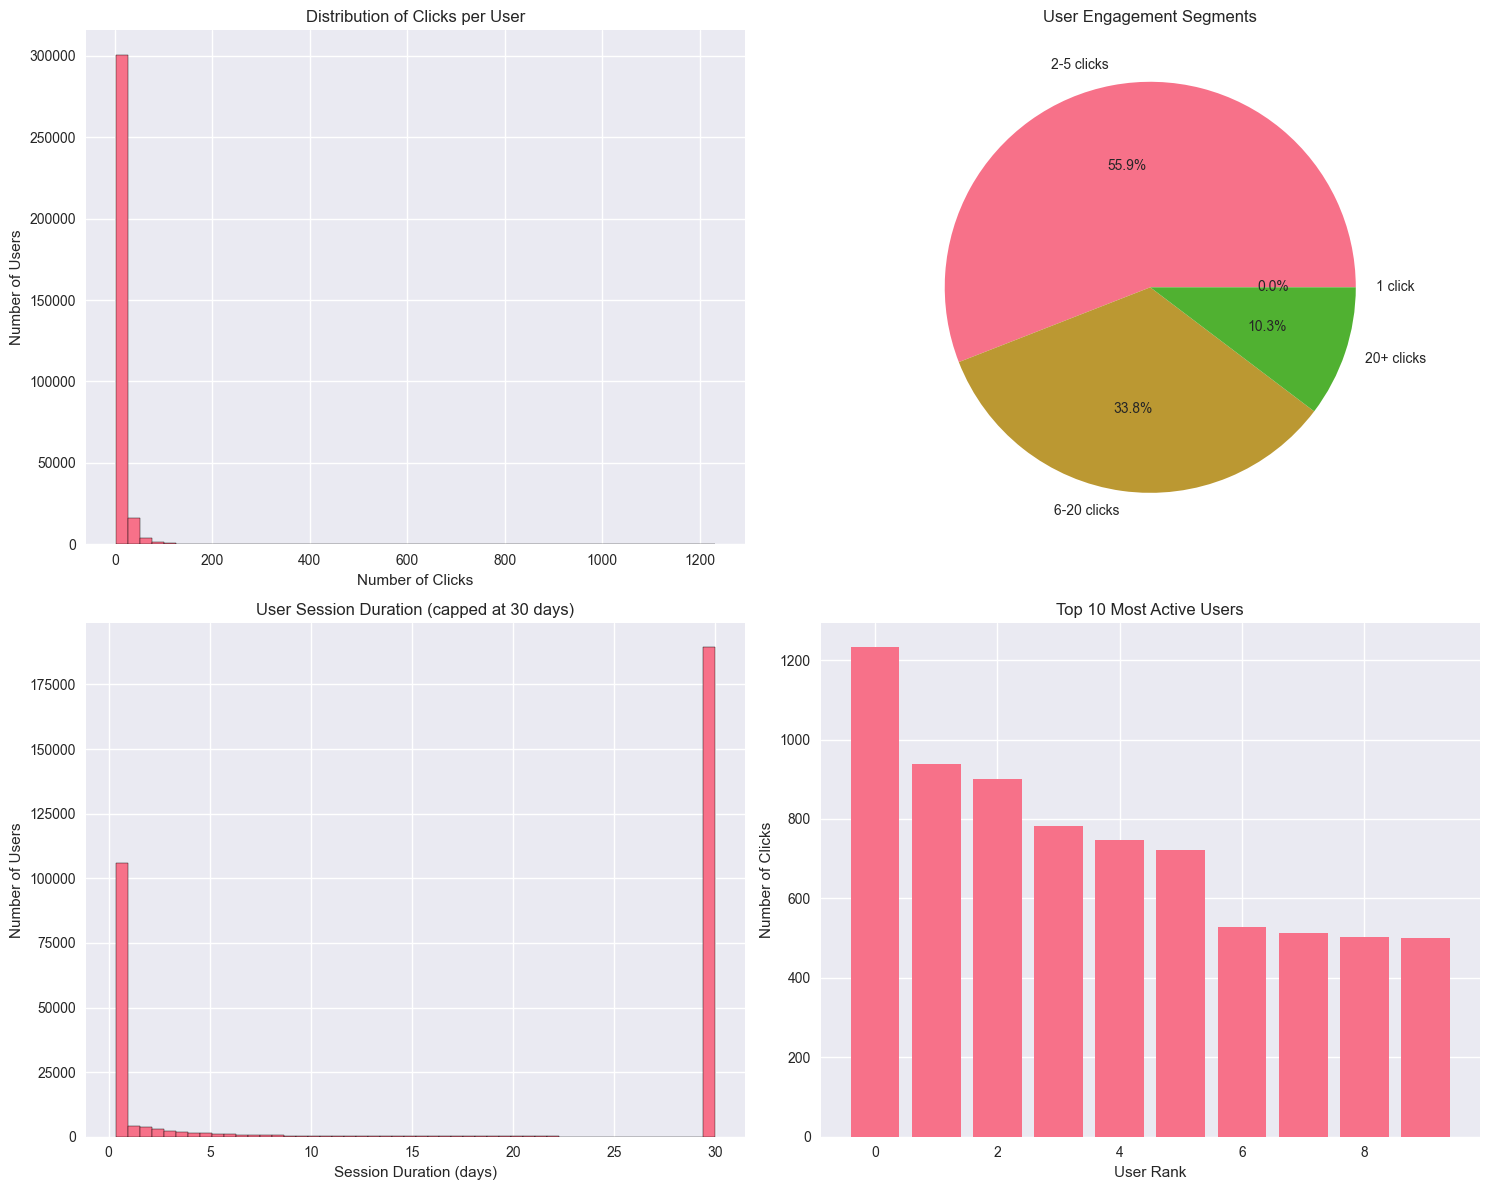

Average clicks per user: 9.25
Median clicks per user: 4.00
Most active user: 1232 clicks
Users with only 1 click: 0
Percentage of single-click users: 0.00%


In [ ]:



# User activity statistics
user_activity = clicks_df.groupby('user_id').agg({
    'click_timestamp': ['count', 'min', 'max']
}).round(2)
user_activity.columns = ['click_count', 'first_click', 'last_click']

# Calculate user session duration (in days)
user_activity['session_days'] = (
    user_activity['last_click'] - user_activity['first_click']
) / (24 * 3600)  # Convert seconds to days

# Plot user behavior
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Distribution of clicks per user
axes[0, 0].hist(user_activity['click_count'], bins=50, edgecolor='black')
axes[0, 0].set_title('Distribution of Clicks per User')
axes[0, 0].set_xlabel('Number of Clicks')
axes[0, 0].set_ylabel('Number of Users')

# User engagement segments
engagement_segments = pd.cut(
    user_activity['click_count'], 
    bins=[0, 1, 5, 20, float('inf')],
    labels=['1 click', '2-5 clicks', '6-20 clicks', '20+ clicks']
)
segment_counts = engagement_segments.value_counts()

axes[0, 1].pie(segment_counts.values, labels=segment_counts.index, autopct='%1.1f%%')
axes[0, 1].set_title('User Engagement Segments')

# Session duration distribution
axes[1, 0].hist(user_activity['session_days'].clip(upper=30), bins=50, edgecolor='black')
axes[1, 0].set_title('User Session Duration (capped at 30 days)')
axes[1, 0].set_xlabel('Session Duration (days)')
axes[1, 0].set_ylabel('Number of Users')

# Top active users
top_users = user_activity.nlargest(10, 'click_count')
axes[1, 1].bar(range(len(top_users)), top_users['click_count'])
axes[1, 1].set_title('Top 10 Most Active Users')
axes[1, 1].set_xlabel('User Rank')
axes[1, 1].set_ylabel('Number of Clicks')

plt.tight_layout()
plt.show()



   

 la data ne semble pas fiable pour determiner le temps passé sur els article:
    Sur les session de 2 article la difference de click_timestamp est toujours identique.
    il n'existe aucune session de 1 article
    l

In [38]:

clicks_df.to_pickle(RATING_PREPROC_DF_PATH)
embeding_df.to_pickle(CANDIDATE_PREPROC_DF_PATH)

# II. Model de recommandation

In [2]:

with open(RATING_PREPROC_DF_PATH , 'rb') as f:
    rating_df = pickle.load(f)
with open(CANDIDATE_PREPROC_DF_PATH , 'rb') as f:
    candidate_df = pickle.load(f)

## A- librairie: implicit vs surprise vs tensorflow reocmmendation:

Implicit n'est pas en V1 et n'a pas vu de commit depuis plus d'un an. Il n'y a pas de documentation hormis  le git.

Surprise est mieux maintenu  et plus cité mais plus orienté explicit qu'implicit

tfrs est ~~bien maintenu~~(non), addossé a tensorflow, et adapté au problème:
https://www.tensorflow.org/recommenders/examples/basic_retrieval





### load as tensor

In [3]:
import tensorflow as tf
import pprint
candidate_tfds = tf.data.Dataset.from_tensor_slices(candidate_df)
rating_tfds = tf.data.Dataset.from_tensor_slices(rating_df)

In [4]:
for x in rating_tfds.take(1).as_numpy_iterator():
  pprint.pprint(x)

array([0.00000000e+00, 1.50682542e+12, 1.57541000e+05, 1.50682683e+12,
       1.40502000e+06, 2.81000000e+02, 1.50680052e+12, 0.00000000e+00,
       2.80000000e+02, 5.01792857e+03])


## B. Model

### Keras+tfrs (too buggy)

In [4]:
from keras import Sequential,layers,Model

import tensorflow_recommenders as tfrs


# Build vocabularies
user_ids_vocabulary = layers.StringLookup(
    vocabulary=rating_df["user_id"].astype(str).unique(), mask_token=None
)
article_ids_vocabulary = layers.StringLookup(
    vocabulary=candidate_df.index.astype(str).unique(), mask_token=None
)

# Define the model
class ArticleRetrievalModel(tfrs.models.Model):

    def __init__(self,
                 user_ids_vocabulary=user_ids_vocabulary,
                 article_ids_vocabulary=article_ids_vocabulary,
                 ):
        super().__init__()


                
        embedding_dim = 64  # dimensionality of learned user/article embeddings
        
        # User tower
        self.user_model = Sequential([
            user_ids_vocabulary,
            layers.Embedding(
                input_dim=user_ids_vocabulary.vocabulary_size(),
                output_dim=embedding_dim)
        ])
        
        # Article tower: combines id + precomputed embedding
        self.article_id_model = Sequential([
            article_ids_vocabulary,
            layers.Embedding(article_ids_vocabulary.vocabulary_size(), 
                             embedding_dim)
        ])
        
        self.article_embedding_projector = Sequential([
            layers.Dense(128, activation="relu"),
            layers.Dense(embedding_dim)
        ])
        
        # Retrieval task
        self.task = tfrs.tasks.Retrieval()

    def article_embedding(self, features):
        # Combine ID-based embedding and precomputed 250D embedding
        id_emb = self.article_id_model(features["article_id"])
        content_emb = self.article_embedding_projector(tf.convert_to_tensor(features["embedding"]))
        return tf.concat([id_emb, content_emb], axis=1)
    
    def compute_loss(self, features, training=False):
        user_embeddings = self.user_model(features["user_id"])
        article_embeddings = self.article_embedding(features)
        
        return self.task(user_embeddings, article_embeddings)


In [5]:
from typing import Dict, Text
import tensorflow as tf

class ArticldeModel(tfrs.Model):

  def __init__(self, user_model, candidate_model, task):
    super().__init__()
    self.candidate_model: Model = candidate_model
    self.user_model: Model = user_model
    self.task: layers.Layer = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # We pick out the user features and pass them into the user model.
    user_embeddings = self.user_model(features["user_id"])
    # And pick out the movie features and pass them into the movie model,
    # getting embeddings back.
    positive_candidate_embeddings = self.candidate_model(features["article_id"])

    # The task computes the loss and the metrics.
    return self.task(user_embeddings, positive_candidate_embeddings)

### Implicit

#### Model architecture


In [3]:
from implicit_model import ArticleRetrievalImplicit



c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\mlflow\pyfunc\utils\data_validation.py:186: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [4]:

retrieval_model = ArticleRetrievalImplicit(rating_df, 
                                           candidate_df, 
                                           factors=64,
                                           model_type='BAY'
                                           )
retrieval_model.train()


Matrix shape: (322897, 46033)
Training ALS model...


100%|██████████| 50/50 [00:06<00:00,  7.71it/s, train_auc=98.30%, skipped=4.99%]

After fit:
user_item shape: (322897, 46033)
Training complete.



#### Metrics

In [4]:
from implicit_model import implicit_evaluation

#### Fonction de recommendation

In [78]:
# Recommend articles for a user
result = retrieval_model.recommend("8", N=5)
print(result)

# Find similar articles
# print(retrieval_model.similar_items('42', N=5))

[{'article_id': '331242', 'score': 7.332470417022705}, {'article_id': '331664', 'score': 6.8674774169921875}, {'article_id': '10253', 'score': 6.760776042938232}, {'article_id': '353786', 'score': 6.688801288604736}, {'article_id': '36160', 'score': 6.6756181716918945}]


## C. Fonction entrainement

#### MLFOW init

In [6]:
import mlflow
import time
import subprocess

def start_local_experiment( host='127.0.0.1',
                            port='8080',
                            uri=r'/mlruns',
                            experiment_name="ArticleRecommendator"
                            ):
    command = f'''mlflow server --host {host}  --port {port} \n
                mlflow ui --backend-store-uri {uri}'''
    print(command)

    result = subprocess.Popen(command, shell=True)

    mlflow.set_tracking_uri(uri=f"http://{host}:{port}")

    mlflow.set_experiment(experiment_name)


#### tfrs

In [ ]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adagrad
from keras.losses import CategoricalCrossentropy

def mlflow_experiment(rating_df = rating_df,
                      candidate_df = candidate_df,
                      ratings_keep= ["user_id","article_id","time_per_word"],
                      candidates_keep = ["article_id"],                      
                      rating_target = 'time_per_word',
                      num_epochs = 5,
                      **kwargs):
    start_time = time.time()
    # convert vocabulary to str
    candidate_df = candidate_df.reset_index()

    ratings_tf =  tf.data.Dataset.from_tensor_slices(dict(rating_df[ratings_keep]))
    candidate_tf = tf.data.Dataset.from_tensor_slices(dict(candidate_df[candidates_keep]))

    candidate_ids = candidate_df["article_id"].astype(str)
    user_ids = rating_df["user_id"].astype(str)
    # candidate_ids = candidate_tf.map(lambda x: x["article_id"])
    # user_ids = ratings_tf.map(lambda x: x["user_id"])

    
    unique_candidate_id = candidate_ids.unique()
    unique_user_ids = user_ids.unique()
    # unique_user_ids = np.unique(np.concatenate(list(user_ids)))


    # Build vocabularies
    user_ids_vocabulary = layers.StringLookup(
        vocabulary=unique_user_ids, mask_token=None
    )
    article_ids_vocabulary = layers.StringLookup(
        vocabulary=unique_candidate_id, mask_token=None
    )

    #SPLIT test/train
    tf.random.set_seed(42)
    shuffled = ratings_tf.shuffle(len(rating_df), seed=42, reshuffle_each_iteration=False)
    train = shuffled.take(int(len(rating_df) * 0.8))
    test = shuffled.skip(int(len(rating_df) * 0.8))


    # model = ArticleRetrievalModel(user_ids_vocabulary=user_ids_vocabulary,
    #                               article_ids_vocabulary=article_ids_vocabulary)
    #LOCAL MODEL
    embedding_dimension = 32
    user_model = Sequential([
                 layers.StringLookup(
                    vocabulary=unique_user_ids, mask_token=None),
                # We add an additional embedding to account for unknown tokens.
                 layers.Embedding(len(unique_user_ids) + 1, embedding_dimension)
                ])
    
    candidate_model = Sequential([
                  layers.StringLookup(
                                    vocabulary=unique_candidate_id, mask_token=None),
                  layers.Embedding(len(unique_candidate_id) + 1, embedding_dimension)
    ])


    

    # article_candidates = (
    #     tf_df.batch(128)
    #     #.map(candidate_model)
    #     .map(model.article_id_model)
    #     # .map(lambda x: (x["article_id"], model.article_embedding(x)))
    #     .cache()
    # )
    article_candidates = candidate_tf.batch(128).map(
                                                    lambda x: candidate_model(x["article_id"])
                                                ).cache()
    
    candidate_embeddings = candidate_model(
        tf.convert_to_tensor(candidate_df["article_id"].astype(str))
    )
    candidate_dataset = tf.data.Dataset.from_tensor_slices({
    "article_id": candidate_df["article_id"].astype(str),
    "embedding": candidate_embeddings  # Your pre-computed embeddings
    })

    # Assign metrics
    # metrics=tfrs.metrics.FactorizedTopK(candidates=article_candidates)

    # Explicitly specify k values and use the brute-force method
    # metrics = tfrs.metrics.FactorizedTopK(
    #     candidates=article_candidates,
    #     ks=[1, 5, 10]  # Add this line
    # )
    # loss=CategoricalCrossentropy()

    task = tfrs.tasks.Retrieval(
        # metrics=metrics,
        # loss = loss
        
    )

    model = ArticldeModel(user_model,candidate_model,task)

    # optimizer=Adagrad(learning_rate=0.1)
    # optimizer=tf.compat.v1.train.AdagradOptimizer(learning_rate=0.1)
    optimizer='adam'
    model.compile(optimizer=optimizer,
                #   loss=loss, 
                #   metrics=metrics
                  )
    
    monitor=kwargs.get('monitor','val_loss')

    callbacks = []
    if kwargs.get('use_tensorboard',False):
        tb = TensorBoard(log_dir='logs', write_graph=True)
        callbacks.append(tb)
    if kwargs.get('use_checkpoint',False):
        mc = ModelCheckpoint(
                            mode='max', 
                            filepath='models-dr/pdilated.weights.h5', 
                            monitor=monitor, 
                            save_best_only='True', 
                            save_weights_only='True', 
                            verbose=1)
        callbacks.append(mc)
    es = EarlyStopping(
                        monitor=monitor,
                        mode='min',
                    #    mode='max', 
                    #    monitor='acc', 
                        patience= kwargs.get('patience',2), 
                        verbose=1)
    callbacks.append(es)

    cached_train = train.batch(8192).cache()
    cached_test = test.batch(4096).cache()

    # model.fit(cached_train, epochs=5)
    with mlflow.start_run() as run:

        # mlflow.tensorflow.autolog()
        history =  model.fit( #fit_generator deprecated
                    cached_train,
                    # steps_per_epoch=train_step_per_epoch,
                    epochs=num_epochs,
                    # verbose=1,
                    validation_data=cached_test,
                    # validation_steps=val_step_per_epoch,
                    # use_multiprocessing=True,
                    # workers=16,
                    # callbacks=callbacks,
                    # max_queue_size=32,
                    )

        process_time = time.time() - start_time


        # Start an MLflow run

        signature = None
        # Infer the model signature
        # if sign_model:
        #     signature = infer_signature(X_train, model.predict(X_train), model_params )


        model_info  = mlflow.keras.log_model(
                                    model=model,        
                                    name=model.name,
                                    signature=signature,
                                    input_example=None,
                                    registered_model_name=f"{model.name}",
                                    )

        
        # hash_id = None
        # try:
        #     import hashlib
        #     hash_id = hashlib.sha256(df.to_string().encode()).hexdigest()
        # except:
        #     pass

        # Log other information about the model
        mlflow.log_params({ "Process_Time": process_time,
                        #    'ModelParams' : model_params,
                            'optimizer':optimizer,
                            # 'loss':loss,
                            'monitor':monitor,
                            # 'GenParams' : gen_params,
                            'Metrics' : metrics,
                            # 'TrainStepPerEpoch' : train_step_per_epoch, #sample/batch_size
                            # 'ValStepPerEpoch' : val_step_per_epoch,
                            'Epochs' : num_epochs,
                            # 'DataHash': hash_id,
                            # 'dataset_path':df_path,
                            # 'dataset_length':len(df.index),
                            
                            })

#### implicit

In [11]:
def mlflow_experiment(rating_df = rating_df,
                      candidate_df = candidate_df,
                      ratings_keep= ["user_id","article_id","time_per_word"],
                      candidates_keep = ["article_id"],                      
                      rating_target = 'time_per_word',
                      train_test_split_perc = 0.8,
                      num_epochs = 5,
                      **kwargs):
    start_time = time.time()
    # convert vocabulary to str
    candidate_df = candidate_df.reset_index()

    rating_df = rating_df[ratings_keep]
    candidate_df = candidate_df[candidates_keep]


    model = ArticleRetrievalImplicit(rating_df=rating_df,
                                     candidate_df=candidate_df,
                                     rating_target=rating_target,
                                     train_test_split_perc = train_test_split_perc,
                                     embeding_alpha= kwargs.get('embeding_alpha',0.8),
                                     factors=kwargs.get('factors',64),
                                     add_embeding_vector=kwargs.get('add_embeding_vector',False)
                                     )  
    
    model.train()

    
    evaluation_dic = implicit_evaluation(model)

    process_time = time.time() - start_time


    with mlflow.start_run() as run:

        for k,v in evaluation_dic.items():
            mlflow.log_metric(k, v)


        signature = None
        params_dic = {}
        params_dic["Process_Time"] = process_time
        params_dic["train_test_split_perc"] = train_test_split_perc
        params_dic["ratings_keep"] = ratings_keep
        params_dic["candidates_keep"] = candidates_keep
        params_dic["rating_target"] = rating_target
        
        for k,v in kwargs.items():
            params_dic[k] = v

        
        model_info  = mlflow.pyfunc.log_model(
                                    python_model=model,        
                                    name=model.name,
                                    signature=signature,
                                    input_example=None,
                                    # registered_model_name=f"{model.name}",
                                    )

        # Log other information about the model
        mlflow.log_params(params_dic)

In [12]:
start_local_experiment()
mlflow_experiment()

mlflow server --host 127.0.0.1  --port 8080 

                mlflow ui --backend-store-uri /mlruns
Matrix shape: (322897, 46033)
Training ALS model...


100%|██████████| 50/50 [00:05<00:00,  9.86it/s, train_auc=98.50%, skipped=4.01%]


After fit:
user_item shape: (322897, 46033)
Training complete.



100%|██████████| 12/12 [00:00<00:00, 2818.12it/s]
2025/11/10 11:36:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run smiling-moose-466 at: http://127.0.0.1:8080/#/experiments/362647451172403616/runs/2991970ab6964b90b95329cf4de9ad11
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/362647451172403616


#### tfrs


https://github.com/tensorflow/recommenders/issues/712 Bug sur la librairie tfrs

In [15]:

mlflow_experiment(rating_df = rating_df,
                candidate_df = candidate_df,
                ratings_keep= ["user_id","article_id","time_per_word"],
                candidates_keep = ["article_id"],                      
                rating_target = 'time_per_word',
                num_epochs = 5,
                )



Epoch 1/5
🏃 View run victorious-bear-318 at: http://127.0.0.1:8080/#/experiments/362647451172403616/runs/805a581d52d14b9fa8b4b930c4151391
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/362647451172403616


UnimplementedError: Graph execution error:

Detected at node sequential_7_1/Cast defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\asyncio\base_events.py", line 645, in run_forever

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\asyncio\base_events.py", line 1999, in _run_once

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\asyncio\events.py", line 88, in _run

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\IPython\core\interactiveshell.py", line 3098, in run_cell

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\IPython\core\interactiveshell.py", line 3153, in _run_cell

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\IPython\core\interactiveshell.py", line 3362, in run_cell_async

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\IPython\core\interactiveshell.py", line 3607, in run_ast_nodes

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\IPython\core\interactiveshell.py", line 3667, in run_code

  File "C:\Users\d0t\AppData\Local\Temp\ipykernel_20992\325857926.py", line 1, in <module>

  File "C:\Users\d0t\AppData\Local\Temp\ipykernel_20992\2487916156.py", line 152, in mlflow_experiment

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 377, in fit

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 220, in function

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 133, in multi_step_on_iterator

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 114, in one_step_on_data

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\tensorflow_recommenders\models\base.py", line 68, in train_step

  File "C:\Users\d0t\AppData\Local\Temp\ipykernel_20992\3168031401.py", line 17, in compute_loss

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\keras\src\layers\layer.py", line 936, in __call__

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\keras\src\ops\operation.py", line 58, in __call__

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\keras\src\models\sequential.py", line 220, in call

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\keras\src\models\functional.py", line 175, in call

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\keras\src\models\functional.py", line 330, in _standardize_inputs

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\keras\src\models\functional.py", line 250, in _convert_inputs_to_tensors

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\keras\src\ops\core.py", line 958, in convert_to_tensor

  File "c:\Users\d0t\anaconda3\envs\projet3\Lib\site-packages\keras\src\backend\tensorflow\core.py", line 160, in convert_to_tensor

Cast int64 to string is not supported
	 [[{{node sequential_7_1/Cast}}]] [Op:__inference_multi_step_on_iterator_1596]

##### Get recommendations

In [ ]:
# Create article dataset with embeddings
article_dataset = tf_df.batch(128).map(lambda x: (
    x["article_id"], model.article_embedding(x)
))

index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
index.index_from_dataset(article_dataset)

user_id = "1"
scores, ids = index(tf.constant([user_id]))
print("Top recommendations for user", user_id, ":", ids[0, :5].numpy())
